## Importing the dependencies

In [1]:
import pandas as pd
import numpy as np
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

## Importing the data

In [2]:
raw_data = pd.read_csv('../sample_data/influentdata.csv',sep=';')
raw_data.datetime = pd.to_datetime(raw_data.datetime)
raw_data.set_index('datetime', inplace=True, drop=True)
raw_data = raw_data.asfreq('2 min')

['CODf', 'COD', 'NH4_N', 'K']


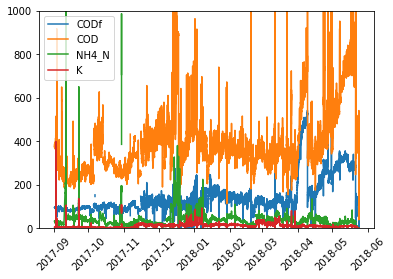

In [5]:
parameters_list = []
for column in raw_data.columns:
    if (('Unit' not in column) & ('equipment' not in column)):
        parameters_list.append(column)
print(parameters_list)
for parameter in parameters_list:
    plt.plot(raw_data.index, raw_data[[parameter]])     
plt.xticks(rotation=45)
plt.ylim([0, 1000])
plt.legend(parameters_list)
plt.show()

In [4]:
start_idx = raw_data.first_valid_index()
end_idx = raw_data.last_valid_index()

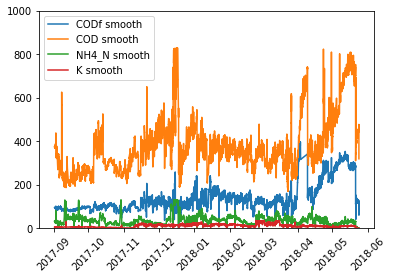

In [6]:
def remove_outliers(df, cols_list):
    for col in cols_list:
        raw_mean = df[col].mean()
        raw_std  = df[col].std()
        df[col+' acc']=df[col].apply(lambda x: ((x>raw_mean-3*raw_std)&(x<raw_mean+3*raw_std)) )
        df[col+' wo_out'] = df[col].loc[df[col+' acc']]
        df[col+' out_refill'] = df[col+' wo_out'].interpolate(method='linear')
        df[col+' smooth'] = df[col+' out_refill'].rolling(window='30T').mean()
    plt.plot(df.index, df[[col+' smooth' for col in cols_list]])
    plt.xticks(rotation=45)
    plt.ylim([0, 1000])
    plt.legend([col+' smooth' for col in cols_list])
    return df
data = remove_outliers(raw_data, parameters_list)

## making an auto-regressive model

In [7]:
def s_3(series, alpha):
    results=[]
    for i in range(len(series)):
        if i < 3:    
            results.append(series.iloc[i])
        else:
            s = alpha*(series.iloc[i]) +\
                (1-alpha)*results[i-1] +\
                ((1-alpha)**2)*results[i-2] +\
                ((1-alpha)**3)*results[i-3]
            results.append(s)
    return results          
                   

In [8]:
def optim_filter(func, df, cols_list):
    from scipy.optimize import curve_fit
    alphas={}
    for col in cols_list:
        print('working on {}'.format(col))
        param,cov =curve_fit(func, df[col+' smooth'][0:-1], df[col+' smooth'][1:])
        alphas[col]=param[0]
        df[col+' predict'] = func(df[col+' smooth'],alphas[col])
        
    plt.plot(df.index, df[[col+' predict' for col in cols_list]])
    plt.legend([col+' predict' for col in cols_list])
    return df

working on CODf


/Users/jeandavidt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning:

overflow encountered in double_scalars



working on COD
working on NH4_N
working on K


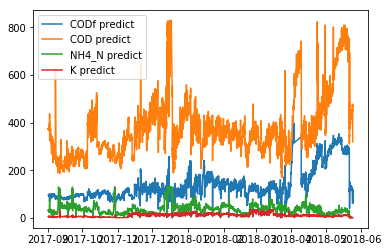

In [9]:
data=optim_filter(s_3, data, parameters_list)

In [10]:
data.head()

,CODf,CODf Unit,CODf equipment,COD,COD Unit,COD equipment,NH4_N,NH4_N Unit,NH4_N equipment,K,...,NH4_N out_refill,NH4_N smooth,K acc,K wo_out,K out_refill,K smooth,CODf predict,COD predict,NH4_N predict,K predict
datetime,,,,,,,,,,,,,,,,,,,,,
2017-09-01 12:02:00,95.408,g/m3,Spectro_010,374.856,g/m3,Spectro_010,32.74,g/m3,Ammo_005,4.9,...,32.74,32.740000,True,4.9,4.9,4.900000,95.408000,374.856000,32.740000,4.900000
2017-09-01 12:04:00,95.530,g/m3,Spectro_010,375.530,g/m3,Spectro_010,33.08,g/m3,Ammo_005,5.0,...,33.08,32.910000,True,5.0,5.0,4.950000,95.469000,375.193000,32.910000,4.950000
2017-09-01 12:06:00,95.481,g/m3,Spectro_010,373.657,g/m3,Spectro_010,33.19,g/m3,Ammo_005,5.0,...,33.19,33.003333,True,5.0,5.0,4.966667,95.473000,374.681000,33.003333,4.966667
2017-09-01 12:08:00,95.109,g/m3,Spectro_010,377.159,g/m3,Spectro_010,33.30,g/m3,Ammo_005,5.0,...,33.30,33.077500,True,5.0,5.0,4.975000,95.402462,375.361145,33.097643,4.977351
2017-09-01 12:10:00,95.860,g/m3,Spectro_010,379.292,g/m3,Spectro_010,33.54,g/m3,Ammo_005,5.1,...,33.54,33.170000,True,5.1,5.1,5.000000,95.500595,376.160787,33.190151,5.002661


# PCA analysis

## PCA using linalg

In [3]:
def multivariate(df,col_name_list, start_cal, end_cal,min_var_exp=0.95, alpha=0.95):
    from sklearn.preprocessing import StandardScaler
    import numpy.linalg as alg
     
    ##### scaling the features
    DF=df.copy()
    scaler=StandardScaler()
    x_raw = df[col_name_list].loc[start_cal:end_cal].values
    x_bar=scaler.fit_transform(x_raw)
    
    ##### singular value decomposition
    svd_feat={}
    svd_feat['u'],svd_feat['s'],p_T = alg.svd(x_bar,full_matrices=False)
    svd_feat['p'] =p_T.T
    svd_feat['cov']=np.dot(x_bar.T,x_bar)/(len(x_bar)-1)
    svd_feat['eigenvalues'] =  svd_feat['s']**2/(len(x_bar)-1)
    svd_feat['Lambda'] = np.diag(svd_feat['eigenvalues'])
    svd_feat['t']=np.dot(svd_feat['u'],np.diag(svd_feat['s']))
    
    
    ##### How much of the variance is explained by the principal components? 
    t_var = []
    n_components=len(col_name_list)
    
    for col in range(n_components):
        t_var.append(svd_feat['t'][:,col].var())
        
    sum_var = np.sum(t_var)
    svd_feat['exp_var'] = np.divide(t_var,sum_var)
    
    ##### Dimension reduction
    # Initializing a model object (dictionnary)
    model ={}
    #info on how the model was calibrated
    model['start_cal'] = start_cal
    model['end_cal'] = end_cal
    
    #What proportion of the variance is explained by the model? Should be over min_var_exp
    explained=0.
    for i in range(n_components):
        explained+=svd_feat['exp_var'][i]
        if (i>0 and explained>min_var_exp):
            model['n_comp'] = i+1
            model['exp_var']=explained
            break
        else:
            continue
    # Splitting the matrices 
    
    t_hat=svd_feat['t'][:,0:model['n_comp']]
    model['t_hat_stdev']=[t_hat[:,i].std() for i in range(model['n_comp'])]
    model['p_hat']=svd_feat['p'][:,0:model['n_comp']]
    x_hat=np.dot(t_hat,model['p_hat'].T)
    model['Lambda_hat']=svd_feat['Lambda'][0:3,0:3]
    
    
    ##### Calculate the limits for fault detection
    def calc_stats(norm_data, model_load, eigenvals_mat):
        n_comp = norm_data.shape[1]
        T2=[]
        Q=[]
        for i in range(len(norm_data)):
            T2.append(np.dot(norm_data[i].T, \
                             np.dot(model_load,\
                                   np.dot(alg.inv(eigenvals_mat),
                                          np.dot(model_load.T,norm_data[i])))))
            
            R = np.identity(n_comp)-np.dot(model_load, model_load.T)
            Q.append(np.dot(np.dot(norm_data[i],R),norm_data[i].T))
            
        Q=np.array(Q)
        T2=np.array(T2)
        return T2, Q
    
    model['T2'], model['Q'] = calc_stats(x_bar,model['p_hat'],model['Lambda_hat'])
    #calculating the limits
    
    limits={}
    
    def calc_limits(data, n_pc, Alpha, eigenvals_vec):
        from scipy.stats import f as fisher
        from scipy.stats import norm as normal
        
        #### T2 stat limit 
        n_data = len(data)
        F_alpha = fisher.interval(Alpha,n_pc,n_data-n_pc)[1]
        T2_lim = (n_pc*(n_data**2-1)/(n_data*(n_data-n_pc)))*F_alpha
        
        #### Q stat limit prior info
        theta=np.zeros([3,])
        for i in range(3):
            for j in range(n_pc+1):
                theta[i]+=eigenvals_vec[j]**(i+1)        
        h_0= 1-((2*theta[0]*theta[2])/(3*theta[1]**2))
        z_alpha = normal.ppf(Alpha)
        
        #### Actual Q stat limit
        Q_lim= theta[0]*\
        (np.dot(z_alpha,np.divide(np.sqrt(2*theta[1]*h_0**2),theta[0]))\
        +1+ np.divide(theta[1]*h_0*(h_0-1),theta[0]**2))**(1/h_0)
        return T2_lim, Q_lim
    
    limits['t2'], limits['Q'] = calc_limits(x_bar, model['n_comp'], alpha, svd_feat['eigenvalues'])
    limits['alpha']=alpha
    
    ##### Applying the model to the df data
    x_totraw = df[col_name_list].values
    x_tot=scaler.transform(x_totraw) 
    t_tot = np.dot(x_tot, model['p_hat'])
    for i in range(model['n_comp']):
        DF['t_'+str(i+1)]=t_tot[:,i]
        
    DF['T2'], DF ['Q'] = calc_stats(x_tot,model['p_hat'],model['Lambda_hat'])
    if 'fault_count' not in DF.columns:
        DF['fault_count'] = 0
    DF['fault_count'].loc[DF['T2']>limits['t2']] +=1
    DF['fault_count'].loc[DF['Q']>limits['Q']] +=1
    
    return DF, limits, svd_feat, model

In [6]:
col_name_list = ['CODf predict','COD predict', 'NH4_N predict', 'K predict']
start_cal, end_cal = 'November 15 2017','December 12 2017'
plt.figure(figsize=(8,5))
cols_to_plot = [col+' predict' for col in parameters_list]
for col in cols_to_plot:
    plt.plot(data.loc[start_cal:end_cal].index, data[col].loc[start_cal: end_cal], alpha=0.5)
plt.legend(cols_to_plot)
plt.show()

NameError: name 'data' is not defined

<Figure size 576x360 with 0 Axes>

In [13]:
testdf, lim, svdtest, modeltest = multivariate(data, col_name_list, start_cal, end_cal)

In [14]:
def show_multi_output(df, cols_list):
    from matplotlib import dates as mdates
    from matplotlib import cm
    fig, axes = plt.subplots(figsize=(20,10),nrows=len(cols_list)+1, ncols=1)
    plt.rc('lines', linewidth=0.5)
    color=iter(cm.plasma(np.linspace(0.05,0.8,len(cols_list)+1)))

    fig.subplots_adjust(hspace=0.5)
    fig.suptitle('Output of multivariate filter')

    for ax, feature in zip(axes.flatten()[:-1], cols_list):

        ax.plot(df.index, df[feature], c=next(color))
        ax.set(ylabel=feature.split(' ')[0].upper() )
        ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

    ax=axes[-1]
    ax.plot(df.index, df['fault_count'], c='k')
    ax.set(ylabel='fault count', xlabel='Date')
    ax.set_xticklabels(df.index,rotation=45)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
    plt.show()


In [15]:
def show_pca(df, limits, svd, model):
    from matplotlib import cm
    import numpy as np
    
    fig, ax = plt.subplots(figsize=(10,10),nrows=1, ncols=1)
    plt.rc('lines', linewidth=1)
    color=iter(cm.plasma(np.linspace(0,1,4)))
    start = model['start_cal']
    end= model['end_cal']
    ax.plot(df['t_1'],df['t_2'],'o',markersize=0.5, c=next(color))
    ax.plot(df['t_1'].loc[start:end],df['t_2'].loc[start:end],'o',markersize=0.5, c=next(color))
    ax.set(ylabel='PC 2', xlabel='PC 1',title='Principal components of calibration and complete data sets')
    #### drawing the ellipse
    
    ellipse_a = np.sqrt(limits['t2'])*model['t_hat_stdev'][0]
    ellipse_b = np.sqrt(limits['t2'])*model['t_hat_stdev'][1]
    t=np.linspace(0,2*np.pi,100)
    
    ax.plot(ellipse_a*np.cos(t), ellipse_b*np.sin(t),c=next(color))
    ax.grid(which='major',axis='both')
    ax.legend(['complete','calibration','limit {}'.format(limits['alpha'])])
    plt.gca().set_aspect('equal')
    plt.show()

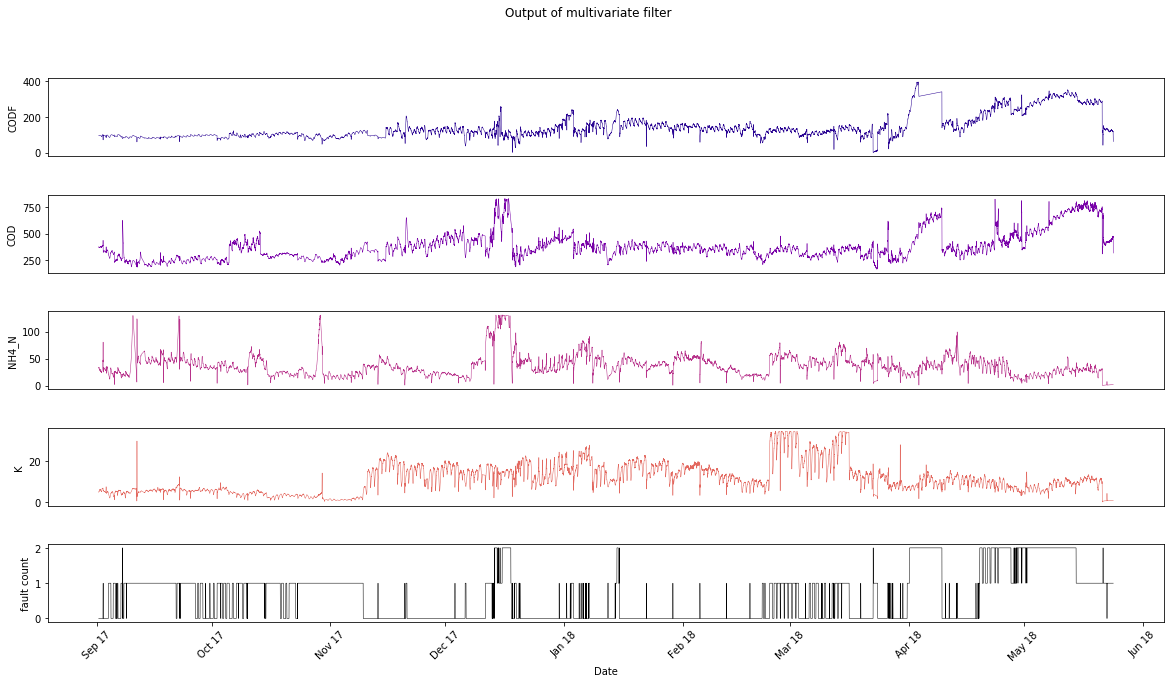

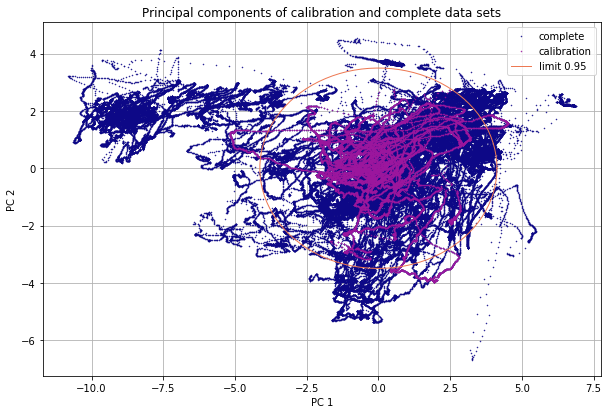

In [16]:
show_multi_output(testdf, col_name_list)
show_pca(testdf, lim, svdtest, modeltest)

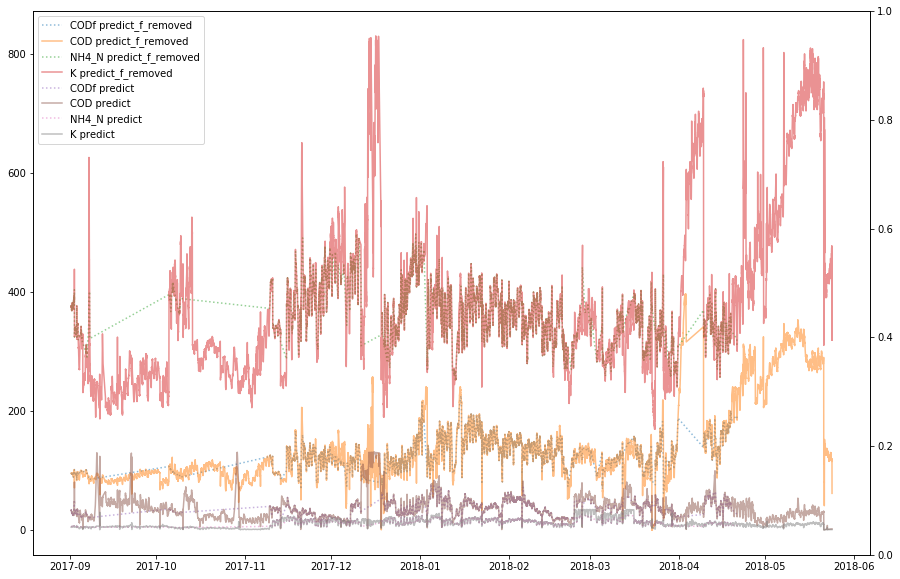

In [61]:
fig, ax1 = plt.subplots(figsize=(15,1))
ax2=ax1.twinx()

cols_to_plot = [col+' predict' for col in parameters_list]
for col in cols_to_plot:
    ax1.plot(testdf.loc[testdf.fault_count==0].index, testdf[col].loc[testdf.fault_count==0], alpha=0.5, linestyle='dotted')
    ax1.plot(testdf.index, testdf[col], alpha=0.5)

ax1.legend([col+'_f_removed' for col in cols_to_plot]+cols_to_plot)
plt.show()

In [18]:
help(plt.plot)

Help on function plot in module matplotlib.pyplot:

plot(*args, scalex=True, scaley=True, data=None, **kwargs)
    Plot y versus x as lines and/or markers.
    
    Call signatures::
    
        plot([x], y, [fmt], data=None, **kwargs)
        plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)
    
    The coordinates of the points or line nodes are given by *x*, *y*.
    
    The optional parameter *fmt* is a convenient way for defining basic
    formatting like color, marker and linestyle. It's a shortcut string
    notation described in the *Notes* section below.
    
    >>> plot(x, y)        # plot x and y using default line style and color
    >>> plot(x, y, 'bo')  # plot x and y using blue circle markers
    >>> plot(y)           # plot y using x as index array 0..N-1
    >>> plot(y, 'r+')     # ditto, but with red plusses
    
    You can use `.Line2D` properties as keyword arguments for more
    control on the appearance. Line properties and *fmt* can be mixed.
    The foll